# Generate Report Results

### 1. 读取20台模拟钟组数据，按num_clocks取前一半相关，后一半无关的部分钟组作为实验对象

In [1]:
import os
import numpy as np

# seed = 100
# num_clocks = 6
seed = os.environ['seed']
num_clocks = int(os.environ['num_clocks'])

print("-------------------Seed = %s, Clock size = %s-------------------" % (seed, num_clocks))

-------------------Seed = 100, Clock size = 6-------------------


In [2]:
# 1. Read data with 0 covariance and 5 covariance
cov_0_dir = "./data/seed%s-0-cov.csv" % seed
cov_20_dir = "./data/seed%s-20-cov.csv" % seed

cov_0_data = np.loadtxt(cov_0_dir, delimiter=',')
cov_20_data = np.loadtxt(cov_20_dir, delimiter=',')
print("Loaded 2 csvs: %s, %s" % (cov_0_dir, cov_20_dir))

Loaded 2 csvs: seed100-0-cov.csv, seed100-20-cov.csv


In [3]:
# 2. Modify to get data with clock_size / 2 clocks covariance and clock_size / 2 clocks covariance not
# Suppose num_clocks = 6, then 3 clock covariance (1,2,3) and 3 not (4,5,6)
stack_list = list()
for i in range(num_clocks):
    if i < num_clocks / 2:
        stack_list.append(cov_20_data[i,:])
    else:
        stack_list.append(cov_0_data[i,:])
cov_mix_data = np.stack(stack_list, axis=0)
print(cov_mix_data.shape)

cov_group_1 = cov_mix_data[1:,]
cov_ref_1 = cov_mix_data[0,]
print("group1 - %s, reference - %s" % (cov_group_1.shape, cov_ref_1.shape))

cov_group_2 = cov_mix_data[:-1,]
cov_ref_2 = cov_mix_data[-1,]
print("group2 - %s, reference - %s" % (cov_group_2.shape, cov_ref_2.shape))

(6, 2591999)
group1 - (5, 2591999), reference - (2591999,)
group2 - (5, 2591999), reference - (2591999,)


In [4]:
# 3. Minus reference group
cov_data_1 = cov_group_1 - cov_ref_1
cov_data_2 = cov_group_2 - cov_ref_2

### 2. 绘制allan方差曲线

In [5]:
# https://allantools.readthedocs.io/en/latest/functions.html
!pip install allantools
import allantools

You should consider upgrading via the 'pip install --upgrade pip' command.


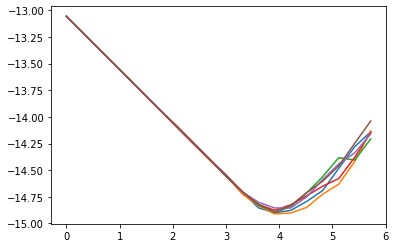

In [6]:
# calculate allan variance for original data
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(cov_mix_data.shape[0]):
    (taus, adevs, errors, ns) = allantools.adev(data=cov_mix_data[i,:], data_type='freq')
    '''
    print('taus - %s' % taus)
    print('adevs - %s' % adevs)
    print("----------------------------------------")
    '''
    plt.plot(np.log10(taus), np.log10(adevs))

### 3. 带入模型进行测试

In [33]:
import sys
import logging

regularization = True

if num_clocks == 6:
    subset_size_list = [3, 5]
elif num_clocks == 10:
    subset_size_list = [3, 5, 9]
elif num_clocks == 20:
    subset_size_list = [5, 10, 19]
    
window_step_list = [60*60*12, 60*60*6, 60*60, 60*30, 60*10, 60*5]
amplify = [2, 2, 5, 5, 10, 10]

window_size_list = [x*y for (x,y) in zip(window_step_list, amplify)]

#### 3.1. cov_data = cov_data_1

In [34]:
cov_data = cov_data_1
y_t = cov_data.T
clock_size = y_t.shape[1]

print("INIT algorithm parameters with num_clocks = %s for cov_data_1" % num_clocks)

INIT algorithm parameters with num_clocks = 6 for cov_data_1


In [50]:
log = logging.getLogger()  # root logger
for hdlr in log.handlers[:]:  # remove all old handlers
    log.removeHandler(hdlr)

result_log_file = "./log/seed%s-%sclock-cov_data_1.log" % (seed, num_clocks)
fileh = logging.FileHandler(result_log_file, 'a')
formatter = logging.Formatter('%(message)s')
fileh.setFormatter(formatter)
log.addHandler(fileh)

print("INIT logging file %s" % result_log_file)

INIT logging file ./log/seed100-6clock-cov_data_1.log


------------------window_size = 86400, window_step = 43200------------------
subset_size - 3, avg_imp - 0.022203338216483036
subset_size - 5, avg_imp - 0.04688114957490071


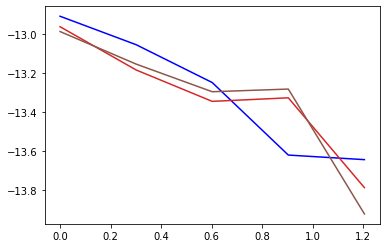

------------------window_size = 43200, window_step = 21600------------------
subset_size - 3, avg_imp - 0.1691193822305698
subset_size - 5, avg_imp - 0.238786517356293


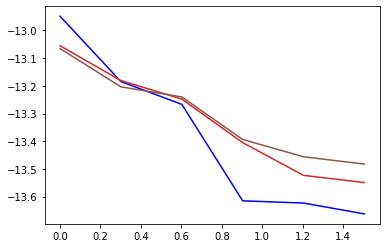

------------------window_size = 18000, window_step = 3600------------------
subset_size - 3, avg_imp - -0.14606223141198096
subset_size - 5, avg_imp - -0.14445624537136773


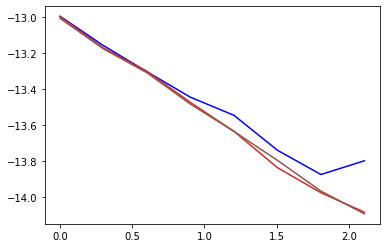

------------------window_size = 9000, window_step = 1800------------------
subset_size - 3, avg_imp - -0.2413802688897459
subset_size - 5, avg_imp - -0.2526537311446566


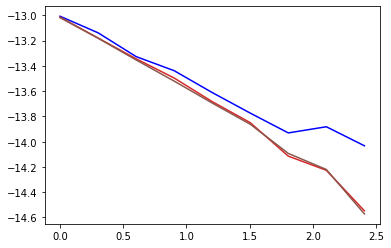

------------------window_size = 6000, window_step = 600------------------
subset_size - 3, avg_imp - -0.19459672479477527
subset_size - 5, avg_imp - -0.21781067114961603


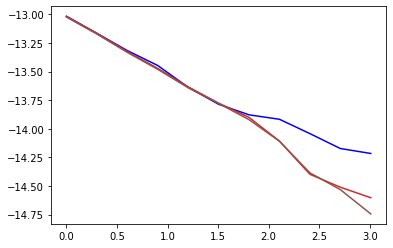

------------------window_size = 3000, window_step = 300------------------
subset_size - 3, avg_imp - -0.18430685768823718
subset_size - 5, avg_imp - -0.19556045657550145


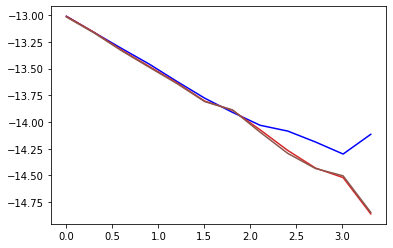

DONE algorithm of num_clocks = 6 for cov_data_1


In [51]:
# 0. For each (window_size, window_step) combination
for window_size, window_step in zip(window_size_list, window_step_list):
    
    if window_size > y_t.shape[0]:
        raise Exception('The window size should not be greater than the number of time points')

    all_weighted_clock_estimation = list()
        
    # 1. For each subset_size
    for subset_size in subset_size_list:
        if subset_size > clock_size:
            raise Exception('The subset size should not be greater than the number of clocks')
        A = np.ones((subset_size, 1))
            
        weighted_inverse_variance_estimation = list()
        weighted_clock_estimation = list()
#         print("------------------Subset size %s------------------" % subset_size)
        
        # 2. For each rolling window
        for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
            subset_cov_list = list()
            subset_raw_list = list()
#             print("------------------Step %s------------------" % i)
                
            # 3. For each subset
            for j in range(clock_size - subset_size + 1):
                
                # 4. Get raw subset
                subset_raw = y_t[i:i+window_size, j:j+subset_size]
        
                # 5. Calculate covariance within the subset
                subset_cov = np.cov(subset_raw, rowvar=False)
                subset_cov_list.append(subset_cov)
#                 print("*** Subset Cov ***")
#                 print(subset_cov)
                
                # 6. Calculate summation for corresponding clocks in different subsets 
                subset_raw_list.append(subset_raw)

            # 7. Calculate covariance matrix mean (Element-wise)
            allset_cov_mean = np.sum(np.asarray(subset_cov_list), axis=0) / (clock_size - subset_size + 1)
#             print("*** Cov mean ***")
#             print(allset_cov_mean)
    
            # 8. Add regularization term
            if regularization:
                sigma = np.max(allset_cov_mean) / (clock_size * 10.0)
                allset_cov_mean += sigma * np.eye(subset_size)
#                 print("*** Regularization term ***")
#                 print(sigma * np.eye(subset_size))
    
            # 9. Calculate the inverse of covariance matrix mean
            allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
#             print("*** Inverse Cov mean ***")
#             print(allset_cov_mean_inverse)
    
            # 10. Calculate weight
            weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
#             print("*** Weight ***")
#             print(weight)

            # 11. Calculate beamformer weighted clock
            subset_corresponding_sum = np.sum(subset_raw_list, axis=0).T
            Z = (np.dot(weight.T, subset_corresponding_sum) / (clock_size - subset_size + 1))[0]
#             print("*** Weighted output ***")
#             print(Z)
    
            # 12. Select the last element in Z as the estimation of weighted clock
            weighted_clock_estimation.append(Z[-1])
    
            # 13. Calculate allan variance for each clock
            inverse_variance = list()
            clock_last_row = list()
            for k in range(clock_size):
                clock = y_t[window_step * i:window_step * i + window_size + 1, k]
                (taus, adevs, errors, ns) = allantools.adev(data=clock, data_type='freq')
                inverse_variance.append(1.0 / (adevs[7] ** 2)) # using allan variance for tau = 2^8
                clock_last_row.append(clock[-1])
            inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
#            print("*** Inverse variance weight ***")
#            print(inverse_variance)
    
            # 14. Calculate the inverse variance weighted clock
            weighted_inverse_variance_clock = np.dot(inverse_variance, np.array(clock_last_row))
            weighted_inverse_variance_estimation.append(weighted_inverse_variance_clock)
#            print("*** Inverse variance weighted clock ***")
#            print(weighted_inverse_variance_clock)
                
        all_weighted_clock_estimation.append(weighted_clock_estimation)

    # 15. Visualize weighted clock estimation and each clock
    log.critical("------------------window_size = %s, window_step = %s------------------" % (window_size, window_step))
    print("------------------window_size = %s, window_step = %s------------------" % (window_size, window_step))
    
    # 16. Calculate Allan deviation
    fig = plt.figure(facecolor='white')
        
    log.critical("*** Inverse variance weighted clock's Allan deviation ***")
    (taus0, adevs0, errors0, ns0) = allantools.adev(data=weighted_inverse_variance_estimation, data_type='freq')
    log.critical('taus - %s, adevs - %s' % (taus0, adevs0))
    plt.plot(np.log10(taus0), np.log10(adevs0), color='blue')
    
    log.critical("*** Weighted clock's Allan deviation ***")
    for subset_size, weighted_clock_estimation in zip(subset_size_list, all_weighted_clock_estimation):
        (taus, adevs, errors, ns) = allantools.adev(data=weighted_clock_estimation, data_type='freq')
        log.critical('taus - %s, adevs - %s' % (taus, adevs))
        color = 'C%s' % subset_size
        plt.plot(np.log10(taus), np.log10(adevs), color=color)
        
        avg_imp = np.sum((adevs - adevs0) / adevs0) / len(taus)
        log.critical("subset_size - %s, avg_imp - %s" % (subset_size, avg_imp))
        print("subset_size - %s, avg_imp - %s" % (subset_size, avg_imp))
        
    '''
    print("*** Each clock's Allan deviation ***")
    real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
    for i in range(real_clock.shape[1]):
        (taus, adevs, errors, ns) = allantools.adev(data=real_clock[:,i], data_type='freq')
        print('taus - %s, adevs - %s' % (taus, adevs))
    '''
            
    plt.show()

print("DONE algorithm of num_clocks = %s for cov_data_1" % num_clocks)

#### 3.2. cov_data = cov_data_2

In [52]:
cov_data = cov_data_2
y_t = cov_data.T
clock_size = y_t.shape[1]

print("INIT algorithm parameters with num_clocks = %s for cov_data_2" % num_clocks)

INIT algorithm parameters with num_clocks = 6 for cov_data_2


In [53]:
log = logging.getLogger()  # root logger
for hdlr in log.handlers[:]:  # remove all old handlers
    log.removeHandler(hdlr)

result_log_file = "./log/seed%s-%sclock-cov_data_2.log" % (seed, num_clocks)
fileh = logging.FileHandler(result_log_file, 'a')
formatter = logging.Formatter('%(message)s')
fileh.setFormatter(formatter)
log.addHandler(fileh)

print("INIT logging file %s" % result_log_file)

INIT logging file ./log/seed100-6clock-cov_data_2.log


------------------window_size = 86400, window_step = 43200------------------


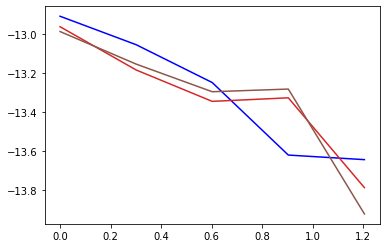

------------------window_size = 43200, window_step = 21600------------------


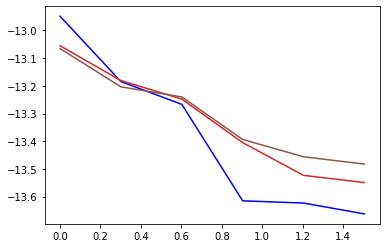

------------------window_size = 18000, window_step = 3600------------------


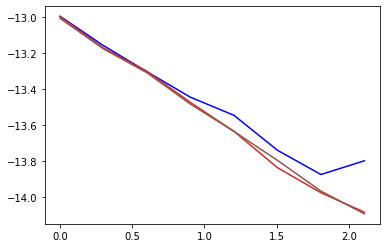

------------------window_size = 9000, window_step = 1800------------------


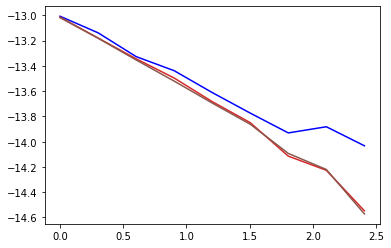

------------------window_size = 6000, window_step = 600------------------


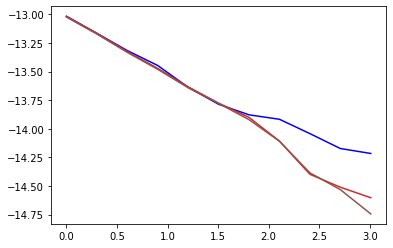

------------------window_size = 3000, window_step = 300------------------


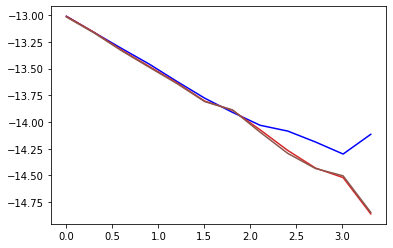

DONE algorithm of num_clocks = 6 for cov_data_2


In [54]:
# 0. For each (window_size, window_step) combination
for window_size, window_step in zip(window_size_list, window_step_list):
    
    if window_size > y_t.shape[0]:
        raise Exception('The window size should not be greater than the number of time points')

    all_weighted_clock_estimation = list()
        
    # 1. For each subset_size
    for subset_size in subset_size_list:
        if subset_size > clock_size:
            raise Exception('The subset size should not be greater than the number of clocks')
        A = np.ones((subset_size, 1))
            
        weighted_inverse_variance_estimation = list()
        weighted_clock_estimation = list()
#         print("------------------Subset size %s------------------" % subset_size)
        
        # 2. For each rolling window
        for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
            subset_cov_list = list()
            subset_raw_list = list()
#             print("------------------Step %s------------------" % i)
                
            # 3. For each subset
            for j in range(clock_size - subset_size + 1):
                
                # 4. Get raw subset
                subset_raw = y_t[i:i+window_size, j:j+subset_size]
        
                # 5. Calculate covariance within the subset
                subset_cov = np.cov(subset_raw, rowvar=False)
                subset_cov_list.append(subset_cov)
#                 print("*** Subset Cov ***")
#                 print(subset_cov)
                
                # 6. Calculate summation for corresponding clocks in different subsets 
                subset_raw_list.append(subset_raw)

            # 7. Calculate covariance matrix mean (Element-wise)
            allset_cov_mean = np.sum(np.asarray(subset_cov_list), axis=0) / (clock_size - subset_size + 1)
#             print("*** Cov mean ***")
#             print(allset_cov_mean)
    
            # 8. Add regularization term
            if regularization:
                sigma = np.max(allset_cov_mean) / (clock_size * 10.0)
                allset_cov_mean += sigma * np.eye(subset_size)
#                 print("*** Regularization term ***")
#                 print(sigma * np.eye(subset_size))
    
            # 9. Calculate the inverse of covariance matrix mean
            allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
#             print("*** Inverse Cov mean ***")
#             print(allset_cov_mean_inverse)
    
            # 10. Calculate weight
            weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
#             print("*** Weight ***")
#             print(weight)

            # 11. Calculate beamformer weighted clock
            subset_corresponding_sum = np.sum(subset_raw_list, axis=0).T
            Z = (np.dot(weight.T, subset_corresponding_sum) / (clock_size - subset_size + 1))[0]
#             print("*** Weighted output ***")
#             print(Z)
    
            # 12. Select the last element in Z as the estimation of weighted clock
            weighted_clock_estimation.append(Z[-1])
    
            # 13. Calculate allan variance for each clock
            inverse_variance = list()
            clock_last_row = list()
            for k in range(clock_size):
                clock = y_t[window_step * i:window_step * i + window_size + 1, k]
                (taus, adevs, errors, ns) = allantools.adev(data=clock, data_type='freq')
                inverse_variance.append(1.0 / (adevs[7] ** 2)) # using allan variance for tau = 2^8
                clock_last_row.append(clock[-1])
            inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
#            print("*** Inverse variance weight ***")
#            print(inverse_variance)
    
            # 14. Calculate the inverse variance weighted clock
            weighted_inverse_variance_clock = np.dot(inverse_variance, np.array(clock_last_row))
            weighted_inverse_variance_estimation.append(weighted_inverse_variance_clock)
#            print("*** Inverse variance weighted clock ***")
#            print(weighted_inverse_variance_clock)
                
        all_weighted_clock_estimation.append(weighted_clock_estimation)

    # 15. Visualize weighted clock estimation and each clock
    log.critical("------------------window_size = %s, window_step = %s------------------" % (window_size, window_step))
    print("------------------window_size = %s, window_step = %s------------------" % (window_size, window_step))
    
    # 16. Calculate Allan deviation
    fig = plt.figure(facecolor='white')
        
    log.critical("*** Inverse variance weighted clock's Allan deviation ***")
    (taus0, adevs0, errors0, ns0) = allantools.adev(data=weighted_inverse_variance_estimation, data_type='freq')
    log.critical('taus - %s, adevs - %s' % (taus0, adevs0))
    plt.plot(np.log10(taus0), np.log10(adevs0), color='blue')
    
    log.critical("*** Weighted clock's Allan deviation ***")
    for subset_size, weighted_clock_estimation in zip(subset_size_list, all_weighted_clock_estimation):
        (taus, adevs, errors, ns) = allantools.adev(data=weighted_clock_estimation, data_type='freq')
        log.critical('taus - %s, adevs - %s' % (taus, adevs))
        color = 'C%s' % subset_size
        plt.plot(np.log10(taus), np.log10(adevs), color=color)
        
        avg_imp = np.sum((adevs - adevs0) / adevs0) / len(taus)
        log.critical("subset_size - %s, avg_imp - %s" % (subset_size, avg_imp))
        
    '''
    print("*** Each clock's Allan deviation ***")
    real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
    for i in range(real_clock.shape[1]):
        (taus, adevs, errors, ns) = allantools.adev(data=real_clock[:,i], data_type='freq')
        print('taus - %s, adevs - %s' % (taus, adevs))
    '''
            
    plt.show()

print("DONE algorithm of num_clocks = %s for cov_data_2" % num_clocks)